In [1]:
import numpy as np
import matplotlib
from matplotlib  import pyplot as plt
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['lines.markeredgewidth'] = 0.5
matplotlib.rcParams['lines.markersize'] = 8

This jupyter notebook contains functions, programs and plots for **APC 523 Lecture 21 on Godunov method for the Euler equations** (copyright Romain Teyssier, Princeton University). 

This notebook contains the basic function to compute the non-linear flux function, as well as convert primitive variables from conservative variables and vice versa.

We have also added an exact Riemann solver for the Euler equations, together with 3 popular approximate Riemann solvers (LLF, HLL and HLLC). 

With these different functions implemented, we finally implement the first-order Godunov method for the Euler equation and test it against several popular 1D test cases proposed by Toto in his book "Riemann solvers and applications".

In [2]:
# This is the ideal gas adiabatic index
# used throughout this notebook
gamma = 1.4

In [3]:
# This function computes conservative variables (rho, rho u, E)
# from primitive variables (rho, u, P)
def prim_to_cons(w):
    u = 0.*w
    # density
    u[0] = w[0]
    # momentum 
    u[1] = w[0]*w[1]
    # total energy E = 0.5 rho u**2 + P/(gamma-1)
    u[2] = 0.5*w[0]*w[1]**2 + w[2]/(gamma-1)
    return u

In [4]:
# This function computes the flux function (rho u, rho u**2+P, u(E+P))
# from primitive variables (rho, u, P)
def prim_to_flux(w):
    f = 0.*w
    # mass flux
    f[0] = w[0]*w[1]
    # momentum flux
    f[1] = w[0]*w[1]**2+w[2]
    # total energy flux
    f[2] = (0.5*w[0]*w[1]**2 + gamma*w[2]/(gamma-1))*w[1]
    return f

In [5]:
# This function computes primitive variables (rho, u, P)
# from conservative variables (rho, rho u, E) 
def cons_to_prim(u):
    w = 0.*u
    # density
    w[0] = u[0]
    # velocity
    w[1] = u[1]/u[0]
    # pressure
    w[2] = (gamma-1)*(u[2]-0.5*w[0]*w[1]**2)
    return w

In [6]:
# This function sets the initial conditions for the various
# shock tube tests (from Toro's book mostly)
def set_ic(x, type = "sod test"):
    n = x.size
    d = np.zeros(n)
    v = np.zeros(n)
    p = np.zeros(n)
    if type == "sod test":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif type == "toro test1":
        for i in range(0,n):
            if (x[i] < 0.3):
                d[i] = 1
                v[i] = 0.75
                p[i] = 1
            else:
                d[i] = 0.125
                v[i] = 0
                p[i] = 0.1
    elif type == "toro test2":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = -2
                p[i] = 0.4
            else:
                d[i] = 1
                v[i] = 2
                p[i] = 0.4
    elif type == "toro test3":
        for i in range(0,n):
            if (x[i] < 0.5):
                d[i] = 1
                v[i] = 0
                p[i] = 1000
            else:
                d[i] = 1
                v[i] = 0
                p[i] = 0.01
    else:
        print("Unkown IC type=",type)
    # convert to conservative variables
    w = np.reshape([d,v,p],(3,n))
    u = prim_to_cons(w)
    return u

In [7]:
# This function implements the boundary conditions
def set_bc(u, type = "periodic"):
    if type == "periodic":
        u[:,0] = u[:,-4]
        u[:,1] = u[:,-3]
        u[:,-1] = u[:,3]
        u[:,-2] = u[:,2]
    elif type == "free":
        u[:,0] = u[:,2]
        u[:,1] = u[:,2]
        u[:,-1] = u[:,-3]
        u[:,-2] = u[:,-3]
    elif type == "wall":
        u[:,0] = u[:,3]
        u[:,1] = u[:,2]
        u[:,-1] = u[:,-4]
        u[:,-2] = u[:,-3]
        u[1,0] = -u[1,3]
        u[1,1] = -u[1,2]
        u[1,-1] = -u[1,-4]
        u[1,-2] = -u[1,-3]
    else:
        print("Unknow BC type")

In [8]:
# Compute the star velocity as a function of pstar
# and its first derivative
def vs(pstar,dk,vk,pk,ck):
    
    # sound speed
    ak = 2/(gamma+1)/dk
    bk = (gamma-1)/(gamma+1)*pk
    
    # rarefaction
    vraref = 2/(gamma-1)*ck*((pstar/pk)**((gamma-1)/(2*gamma))-1)
    dvraref = (pstar/pk)**(-(gamma+1)/(2*gamma))/(dk*ck)
    
    # shock
    vshock = (pstar-pk)*np.sqrt(ak/(pstar+bk))
    dvshock = (1-(pstar-pk)/(2*(pstar+bk)))*np.sqrt(ak/(pstar+bk))
    
    # choose
    v = np.where(pstar<pk,vraref,vshock)
    dv = np.where(pstar<pk,dvraref,dvshock)
    
    return v, dv

In [9]:
# This function evaluate the exact Riemann solution 
# at coordinate S=x/t for a given input left and right states.
# Outputs are density, velocity and pressure.
def riemann_exact_solution(S,wleft,wright):
    
    # collect left primitive variables
    dl = wleft[0]
    vl = wleft[1]
    pl = wleft[2]

    # collect right primitive variables
    dr = wright[0]
    vr = wright[1]
    pr = wright[2]

    # compute sound speed
    cl = np.sqrt(gamma*pl/dl)
    cr = np.sqrt(gamma*pr/dr)

    # acoustic first guess
    doco = 0.5*(dl*cl+dr*cr)
    pstar = np.maximum(0.5*(pl+pr)+doco*(vl-vr),1e-10)
    
    # raphson-newton iterations
    for iter in range(0,6):
        vstarl, dvstarl = vs(pstar,dl,vl,pl,cl)
        vstarr, dvstarr = vs(pstar,dr,vr,pr,cr)
        f = vr + vstarr - vl + vstarl
        df = dvstarl + dvstarr
        pstar = pstar - f / df
        
    # compute vstar
    vstarl, dvstarl = vs(pstar,dl,vl,pl,cl)
    vstarr, dvstarr = vs(pstar,dr,vr,pr,cr)
    vstar = 0.5*(vl+vr) + 0.5*(vstarr - vstarl)
#    print("p*=",pstar,"v*=",vstar)
    
    # sample solution at x/t=S

    # left to the contact
    if (S < vstar):
        
        # left rarefaction 
        if(pstar < pl):
            Shead = vl - cl
            # left unperturbed state
            if(S < Shead):
                dg = dl
                vg = vl
                pg = pl
            else:
                cstar = cl*(pstar/pl)**((gamma-1)/(2*gamma))
                Stail = vstar - cstar
                # rarefaction fan
                if(S < Stail):
                    dg = dl*(2/(gamma+1)+(gamma-1)/(gamma+1)*(vl-S)/cl)**(2/(gamma-1))
                    vg = (gamma-1)/(gamma+1)*vl + 2/(gamma+1)*(S+cl)
                    pg = pl*(dg/dl)**gamma
                # left star state
                else:
                    dg = dl*(pstar/pl)**(1/gamma)
                    vg = vstar
                    pg = pstar
                    
        # left shock
        else:
            al = 2/(gamma+1)/dl
            bl = (gamma-1)/(gamma+1)*pl
            Sshock = vl - np.sqrt((pstar+bl)/(dl**2*al))
            # left unperturbed state
            if(S < Sshock):
                dg = dl
                vg = vl
                pg = pl
            # left star state
            else:
                dg = dl*((gamma-1)/(gamma+1)+pstar/pl)/(1+(gamma-1)/(gamma+1)*pstar/pl)
                vg = vstar
                pg = pstar

    # right to contact
    else:
        
        # right rarefaction 
        if(pstar < pr):
            Shead = vr + cr
            # right unperturbed state
            if(S > Shead):
                dg = dr
                vg = vr
                pg = pr
            else:
                cstar = cr*(pstar/pr)**((gamma-1)/(2*gamma))
                Stail = vstar + cstar
                # rarefaction fan
                if(S > Stail):
                    dg = dr*(2/(gamma+1)+(gamma-1)/(gamma+1)*(S-vr)/cr)**(2/(gamma-1))
                    vg = (gamma-1)/(gamma+1)*vr + 2/(gamma+1)*(S-cr)
                    pg = pr*(dg/dr)**gamma
                # right star state
                else:
                    dg = dr*(pstar/pr)**(1/gamma)
                    vg = vstar
                    pg = pstar
                    
        # right shock
        else:
            ar = 2/(gamma+1)/dr
            br = (gamma-1)/(gamma+1)*pr
            Sshock = vr + np.sqrt((pstar+br)/(dr**2*ar))
            # right unperturbed state
            if(S > Sshock):
                dg = dr
                vg = vr
                pg = pr
            # right star state
            else:
                dg = dr*((gamma-1)/(gamma+1)+pstar/pr)/(1+(gamma-1)/(gamma+1)*pstar/pr)
                vg = vstar
                pg = pstar
    return dg,vg,pg

In [10]:
# We test the exact Riemann solver using Sod test
wleft=[1,0,1]
wright=[0.125,0.,0.1]
x=np.linspace(0,1,1025)
t=0.245
d=0.*x
v=0.*x
p=0.*x
for i in range(0,1025):
    s=(x[i]-0.5)/t
    dg,vg,pg = riemann_exact_solution(s,wleft,wright)
    d[i]=dg
    v[i]=vg
    p[i]=pg

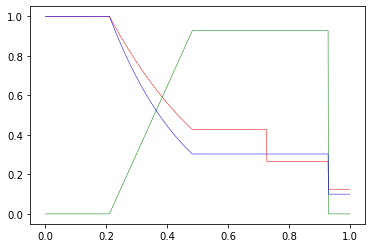

In [11]:
plt.plot(x,d,"r-")
plt.plot(x,v,"g-")
plt.plot(x,p,"b-")

In [12]:
# This function implements the local Lax Friedrich approximate Riemann solver
def riemann_llf(wleft,wright):
    uleft = prim_to_cons(wleft)
    uright = prim_to_cons(wright)
    fleft = prim_to_flux(wleft)
    fright = prim_to_flux(wright)
    sleft = abs(wleft[1])+np.sqrt(gamma*wleft[2]/wleft[0])
    sright = abs(wright[1])+np.sqrt(gamma*wright[2]/wright[0])
    smax = np.maximum(sleft,sright)
    flux = 0.5*(fleft+fright)-0.5*smax*(uright-uleft)
    return flux

In [13]:
# This function implements the HLL approximate Riemann solver
def riemann_hll(wleft,wright):
    ul = prim_to_cons(wleft)
    ur = prim_to_cons(wright)
    fl = prim_to_flux(wleft)
    fr = prim_to_flux(wright)
    cl = np.sqrt(gamma*wleft[2]/wleft[0])
    cr = np.sqrt(gamma*wright[2]/wright[0])
    sl = np.minimum(wleft[1],wright[1])-np.maximum(cl,cr)
    sr = np.maximum(wleft[1],wright[1])+np.maximum(cl,cr)
    fstar = ((fl*sr-fr*sl)+sl*sr*(ur-ul))/(sr-sl)
    flux = np.where(sl>0,fl,np.where(sr>0,fstar,fr))
    return flux

In [14]:
# This function implements the HLLC approximate Riemann solver
def riemann_hllc(wleft,wright):
    flux = 0.*wleft
    uleft = prim_to_cons(wleft)
    uright = prim_to_cons(wright)
    # left state
    dl = wleft[0]
    vl = wleft[1]
    pl = wleft[2]
    el = uleft[2]
    # right state
    dr = wright[0]
    vr = wright[1]
    pr = wright[2]
    er = uright[2]
    # sound speed
    cl = np.sqrt(gamma*pl/dl)
    cr = np.sqrt(gamma*pr/dr)
    # waves speed
    sl = np.minimum(vl,vr)-np.maximum(cl,cr)
    sr = np.maximum(vl,vr)+np.maximum(cl,cr)
    dcl = dl*(vl-sl)
    dcr = dr*(sr-vr)
    # star state velocity and pressure 
    vstar = (dcl*vl+dcr*vr+pl-pr)/(dcl+dcr)
    pstar = (dcl*pr+dcr*pl+dcl*dcr*(vl-vr))/(dcl+dcr)
    # left and right star states
    dstarl = dl*(sl-vl)/(sl-vstar)
    dstarr = dr*(sr-vr)/(sr-vstar)
    estarl = ((sl-vl)*el-pl*vl+pstar*vstar)/(sl-vstar)
    estarr = ((sr-vr)*er-pr*vr+pstar*vstar)/(sr-vstar)
    # sample godunov state
    dg = np.where(sl>0,dl,np.where(vstar>0,dstarl,np.where(sr>0,dstarr,dr)))
    vg = np.where(sl>0,vl,np.where(vstar>0,vstar ,np.where(sr>0,vstar ,vr)))
    pg = np.where(sl>0,pl,np.where(vstar>0,pstar ,np.where(sr>0,pstar ,pr)))
    eg = np.where(sl>0,el,np.where(vstar>0,estarl,np.where(sr>0,estarr,er)))
    # compute godunov flux
    flux[0] = dg*vg
    flux[1] = dg*vg*vg+pg
    flux[2] = (eg+pg)*vg
    return flux

In [15]:
# This function implements the exact Riemann solver
def riemann_exact(wleft,wright):
    flux = 0*wleft        
    for i in range(0,np.size(wleft,1)):
        dg,vg,pg = riemann_exact_solution(0,wleft[:,i],wright[:,i])
        wg = np.reshape([dg,vg,pg],(3))
        fg = prim_to_flux(wg)
        flux[:,i] = fg
    return flux

In [16]:
# This function solves various shock tube tests using Godunov first-order scheme
# for the Euler equations in 1D.
def godunov(tend = 1, n = 100, ic_type = "sod test", bc_type = "periodic", riemann_solver="llf"):

    # set run parameters
    h = 1/n
    nitermax = 1000
    print("cell=", n)

    # set grid geometry
    xf = np.linspace(0,1,n+1)
    x = 0.5*(xf[1:]+xf[:-1])
    
    # allocate permanent storage
    u = np.zeros([nitermax+1,3,n])

    # set initial conditions
    u[0] = set_ic(x,ic_type)
    
    # allocate temporary workspace
    uold = np.zeros([3,n+4])     
    
    # init time and iteration counter
    t = 0
    niter = 1

    # main time loop
    while(t<tend and niter <= nitermax):
        
        uold[:,2:-2] = u[niter-1]     # copy old solution
        set_bc(uold,bc_type)              # set boundary conditions
        
        wold = cons_to_prim(uold)            # compute old primitive variables
        cold = np.sqrt(gamma*wold[2]/wold[0])  # compute old sound speed
        dt = 0.8*h/max(abs(wold[1])+cold)    # compute time step from Courant condition
        
        wleft = wold[:,1:-2]            # left state of Riemann problem
        wright = wold[:,2:-1]          # right state of Riemann problem
        
        if(riemann_solver == 'llf'):   # LLF Riemann solver
            flux = riemann_llf(wleft,wright)

        if(riemann_solver == 'hll'):   # HLL Riemann solver
            flux = riemann_hll(wleft,wright)

        if(riemann_solver == 'hllc'):  # HLLC Riemann solver
            flux = riemann_hllc(wleft,wright)

        if(riemann_solver == 'exact'): # exact Riemann solver
            flux = riemann_exact(wleft,wright)
                    
        uold[:,2:-2] = uold[:,2:-2]-dt/h*(flux[:,1:]-flux[:,:-1])   # update solution
        u[niter] = uold[:,2:-2]         # store new solution
        t = t+dt                  # update time
#        print(niter,t,dt)
        niter = niter+1       # update iteration counter

    print("Done ",niter-1,t)
    return u[0:niter]

In [17]:
# We solve Sod test using our 4 different Riemann solvers
u1=godunov(tend=0.15, n=100, ic_type = "sod test", bc_type = "free", riemann_solver = "exact")
u2=godunov(tend=0.15, n=100, ic_type = "sod test", bc_type = "free", riemann_solver = "llf")
u3=godunov(tend=0.15, n=100, ic_type = "sod test", bc_type = "free", riemann_solver = "hll")
u4=godunov(tend=0.15, n=100, ic_type = "sod test", bc_type = "free", riemann_solver = "hllc")

cell= 100
Done  40 0.1514415767264728
cell= 100
Done  39 0.15165497124513785
cell= 100
Done  40 0.15327625504970868
cell= 100
Done  40 0.15175001697438154


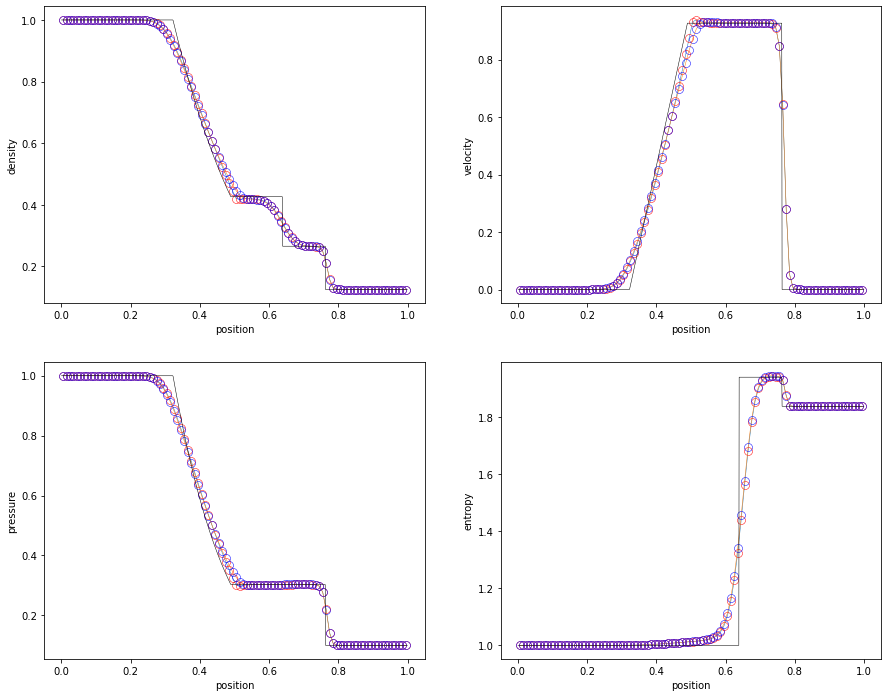

In [18]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:]) # exact Riemann solver
w2 = cons_to_prim(u4[-1,:,:]) # HLLC Riemann solver

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.15
    d,v,p = riemann_exact_solution(s,[1,0,1],[0.125,0,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("density")
#ax1.set_ylim([0,1])
ax1.plot(x1,w1[0,:],marker='o',linestyle='solid', mfc='none', mec='r')
ax1.plot(x1,w2[0,:],marker='o',linestyle='solid', mfc='none', mec='b')
ax1.plot(xana,wana[0,:],"k")

ax2.set_xlabel("position")
ax2.set_ylabel("velocity")
#ax2.set_ylim([-2,2])
ax2.plot(x1,w1[1,:],marker='o',linestyle='solid', mfc='none', mec='r')
ax2.plot(x1,w2[1,:],marker='o',linestyle='solid', mfc='none', mec='b')
ax2.plot(xana,wana[1,:],"k")

ax3.set_xlabel("position")
ax3.set_ylabel("pressure")
#ax3.set_ylim([0,1])
ax3.plot(x1,w1[2,:],marker='o',linestyle='solid', mfc='none', mec='r')
ax3.plot(x1,w2[2,:],marker='o',linestyle='solid', mfc='none', mec='b')
ax3.plot(xana,wana[2,:],"k")

ax4.set_xlabel("position")
ax4.set_ylabel("entropy")
#ax4.set_ylim([0.7,2.5])
ax4.plot(x1,w1[2,:]/w1[0,:]**gamma,marker='o',linestyle='solid', mfc='none', mec='r')
ax4.plot(x1,w2[2,:]/w2[0,:]**gamma,marker='o',linestyle='solid', mfc='none', mec='b')
ax4.plot(xana,wana[2,:]/wana[0,:]**gamma,"k")

plt.savefig('sod_test.png')

In [19]:
u1=godunov(tend=0.245, n=128, ic_type = "sod test", bc_type = "free", riemann_solver = "exact")
u2=godunov(tend=0.245, n=128, ic_type = "sod test", bc_type = "free", riemann_solver = "llf")
u3=godunov(tend=0.245, n=128, ic_type = "sod test", bc_type = "free", riemann_solver = "hll")
u4=godunov(tend=0.245, n=128, ic_type = "sod test", bc_type = "free", riemann_solver = "hllc")

cell= 128
Done  85 0.24662714407086173
cell= 128
Done  84 0.24699140761888372
cell= 128
Done  84 0.24515945860159824
cell= 128
Done  85 0.24676639518340637


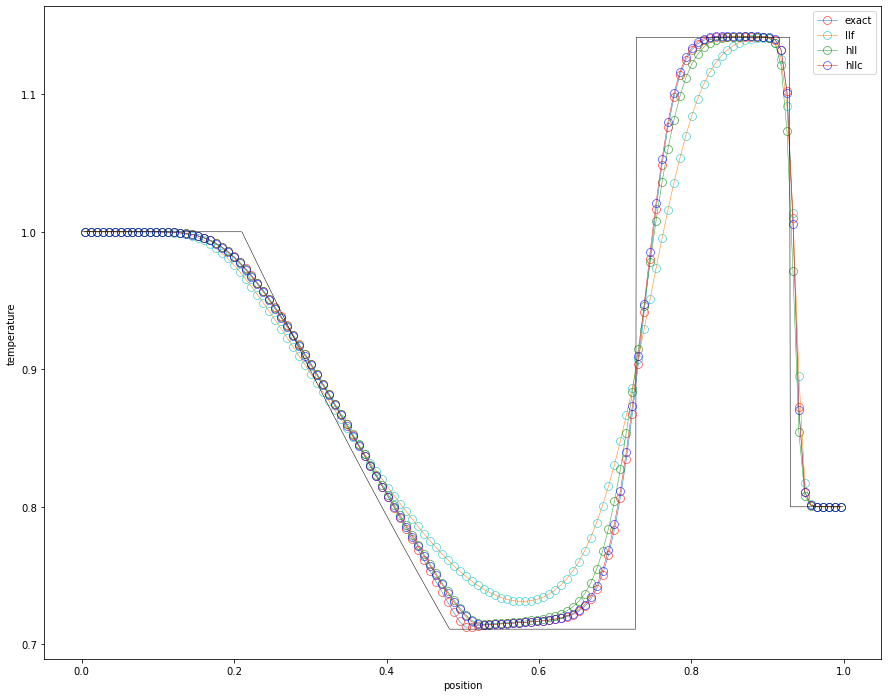

In [20]:
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(111)

x1 = (np.arange(u1.shape[2])+0.5)/u1.shape[2]
w1 = cons_to_prim(u1[-1,:,:])
w2 = cons_to_prim(u2[-1,:,:])
w3 = cons_to_prim(u3[-1,:,:])
w4 = cons_to_prim(u4[-1,:,:])

# compute exact solution
xana = (np.arange(1024)+0.5)/1024
wana = np.zeros([3,1024])
for i in range(0,np.size(xana)):
    s = (xana[i]-0.5)/0.245
    d,v,p = riemann_exact_solution(s,[1,0,1],[0.125,0.,0.1])
    wana[:,i]=[d,v,p]

ax1.set_xlabel("position")
ax1.set_ylabel("temperature")
ax1.plot(x1,w1[2,:]/w1[0,:],marker='o',linestyle='solid', mfc='none', mec='r',label="exact")
ax1.plot(x1,w2[2,:]/w2[0,:],marker='o',linestyle='solid', mfc='none', mec='c',label="llf")
ax1.plot(x1,w3[2,:]/w3[0,:],marker='o',linestyle='solid', mfc='none', mec='g',label="hll")
ax1.plot(x1,w4[2,:]/w4[0,:],marker='o',linestyle='solid', mfc='none', mec='b',label="hllc")
ax1.plot(xana,wana[2,:]/wana[0,:],"k")

ax1.legend()

plt.savefig('riemann_comp.png')